In [89]:
import os
import numpy as np
import pandas as pd
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [90]:
cd "D:\Depaul\DATA_SCIENCE\prog_ml_apps\DATASET\archive (5)"


D:\Depaul\DATA_SCIENCE\prog_ml_apps\DATASET\archive (5)


In [91]:
data = pd.read_csv('Data_Entry_2017.csv')

my_glob = glob('images*/images/*.png')

# Step 2: Map image basenames to their absolute paths
all_image_paths = {os.path.basename(x): x for x in my_glob}

print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(all_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x[:-1])if isinstance(x, str)else x)
data.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
49866,00012628_070.png,Effusion|Infiltration,70,12628,51,F,AP,2500,2048,0.168,0.168,NaN,images_006\images\00012628_070.png
63759,00015732_041.png,Atelectasis|Infiltration|Nodule,41,15732,48,F,AP,2500,2048,0.168,0.168,NaN,images_007\images\00015732_041.png
85369,00021036_002.png,Pneumothorax,2,21036,39,F,PA,2538,2665,0.143,0.143,NaN,images_010\images\00021036_002.png


In [92]:
# Assuming `data` is already loaded
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', '') if pd.notnull(x) else '')
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1:  # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6869,00001836_055.png,,55,1836,49,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92490,00023089_003.png,Effusion|Infiltration,3,23089,58,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
57848,00014326_000.png,,0,14326,43,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [94]:
MIN_CASES = 1000
#all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
all_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (6) [('Effusion', 13317), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Atelectasis', 11559), ('Pneumothorax', 5302)]


In [95]:
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(100000, weights=sample_weights, replace=True)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2666 to 2695
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  100000 non-null  object 
 1   Finding Labels               100000 non-null  object 
 2   Follow-up #                  100000 non-null  int64  
 3   Patient ID                   100000 non-null  int64  
 4   Patient Age                  100000 non-null  int64  
 5   Patient Gender               100000 non-null  object 
 6   View Position                100000 non-null  object 
 7   OriginalImage[Width          100000 non-null  int64  
 8   Height]                      100000 non-null  int64  
 9   OriginalImagePixelSpacing[x  100000 non-null  float64
 10  y]                           100000 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         100000 non-null  object 
 13  Ate

In [97]:
# Dropping unnecessary columns
columns_to_drop = ['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 
                   'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
data = data.drop(columns=[col for col in columns_to_drop if col in data])


In [98]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

counts = data['Finding Labels'].value_counts()
mask = data['Finding Labels'].isin(counts[counts >= 251].index)
data = data[mask]

threshold = 0.75
category_to_delete = ''  # Add appropriate category to delete

# Select rows with the specified category
category_rows = data[data['Finding Labels'] == category_to_delete]

# Calculate the number of rows to delete
num_rows_to_delete = int(len(category_rows) * threshold)

# Randomly select rows to delete
rows_to_delete = np.random.choice(category_rows.index, size=num_rows_to_delete, replace=False)


In [99]:
# Delete selected rows from the DataFrame
data = data.drop(rows_to_delete)
# Calculate the sum of diseases per patient

data['Total Diseases'] = data[all_labels].sum(axis=1)
# Filter patients with exactly one disease
data_one_disease = data[data['Total Diseases'] == 1]


train_df, valid_df = train_test_split(data_one_disease, test_size=0.2, random_state=123)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 33191 validation 8298


In [100]:
# # Calculate the sum of diseases per patient
# train_df['Total Diseases'] = train_df[all_labels].sum(axis=1)

# # Filter patients with exactly one disease
# one_disease_df = train_df[train_df['Total Diseases'] == 1]

In [101]:
data_one_disease.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41489 entries, 2666 to 2695
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image Index         41489 non-null  object 
 1   Finding Labels      41489 non-null  object 
 2   path                41489 non-null  object 
 3   Atelectasis         41489 non-null  float64
 4   Cardiomegaly        41489 non-null  float64
 5   Consolidation       41489 non-null  float64
 6   Edema               41489 non-null  float64
 7   Effusion            41489 non-null  float64
 8   Emphysema           41489 non-null  float64
 9   Fibrosis            41489 non-null  float64
 10  Hernia              41489 non-null  float64
 11  Infiltration        41489 non-null  float64
 12  Mass                41489 non-null  float64
 13  Nodule              41489 non-null  float64
 14  Pleural_Thickening  41489 non-null  float64
 15  Pneumonia           41489 non-null  float64
 16  Pneumot

In [103]:

"""
## for testting purpose 10 iages per each class
#Function to sample 10 images per class
def sample_images_per_class(df, labels, num_samples=10):
    sampled_df = pd.DataFrame()
    for label in labels:
        label_df = df[df[label] == 1]
        sampled_label_df = label_df.sample(min(num_samples, len(label_df)))
        sampled_df = pd.concat([sampled_df, sampled_label_df])
    return sampled_df

train_df = sample_images_per_class(data_one_disease, all_labels, num_samples=10)
valid_df = sample_images_per_class(valid_df, all_labels, num_samples=10)
print('Sampled train', train_df.shape[0], 'Sampled validation', valid_df.shape[0])
"""


Sampled train 60 Sampled validation 60


In [104]:
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip=True, 
                              vertical_flip=False, 
                              height_shift_range=0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

In [105]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                              class_mode='sparse',
                                              **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''  # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [106]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [107]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='newLabel',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='newLabel',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=256)  # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col='newLabel',
                                                   class_mode='categorical',
                                                   classes=all_labels,
                                                   target_size=IMG_SIZE,
                                                   color_mode='rgb',
                                                   batch_size=1024))

Found 60 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


In [108]:
t_x, t_y = next(train_gen)

In [109]:
# def dense_block(x, blocks):
#     for _ in range(blocks):
#         x1 = layers.BatchNormalization()(x)
#         x1 = layers.Activation('relu')(x1)
#         x1 = layers.Conv2D(32, kernel_size=3, padding='same')(x1)
#         x = layers.Concatenate()([x, x1])
#     return x

# def transition_block(x):
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(128, kernel_size=1, padding='same')(x)
#     x = layers.AveragePooling2D(pool_size=2, strides=2)(x)
#     return x

# def create_densenet121(input_shape, num_classes):
#     inputs = tf.keras.Input(shape=input_shape)
#     x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

#     x = dense_block(x, 6)
#     x = transition_block(x)

#     x = dense_block(x, 12)
#     x = transition_block(x)

#     x = dense_block(x, 24)
#     x = transition_block(x)

#     x = dense_block(x, 16)

#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.GlobalAveragePooling2D()(x)

#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model


In [110]:
# # Define input shape and number of classes
# input_shape = (128, 128, 3)

# # Create the model
# model = create_densenet121(input_shape, len(all_labels))

# # Print the model summary
# model.summary()

In [111]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'mae'])

# from keras.callbacks import ModelCheckpoint, EarlyStopping

# weight_path = "xray_class_weights.best.weights.h5"

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
# early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
# callbacks_list = [checkpoint, early]

In [112]:
type(train_gen)

keras.src.legacy.preprocessing.image.DataFrameIterator

In [113]:
# Train the model
# model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=callbacks_list)
#model.fit(train_gen, validation_data=valid_gen, epochs=10)

In [114]:
# # Predicting and calculating the metrics
# pred_Y = model.predict(test_X, batch_size=32, verbose=True)
# pred_labels = np.argmax(pred_Y, axis=1)
# true_labels = np.argmax(test_Y, axis=1)

# precision = precision_score(true_labels, pred_labels, average='weighted')
# recall = recall_score(true_labels, pred_labels, average='weighted')
# f1 = f1_score(true_labels, pred_labels, average='weighted')

# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1)


In [115]:
# # Plotting ROC Curves
# fig, c_ax = plt.subplots(1, 1, figsize=(6, 6))
# for (idx, c_label) in enumerate(all_labels):
#     fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), pred_Y[:, idx])
#     c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# fig.savefig('barely_trained_net.png')

# USING PRE TRAINED WEIGHTS

In [116]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def dense_block(x, blocks):
    for _ in range(blocks):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(32, kernel_size=3, padding='same')(x1)
        x = layers.Concatenate()([x, x1])
    return x

def transition_block(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, kernel_size=1, padding='same')(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(x)  # Use padding='same' to avoid reducing dimensions too much
    return x

def create_densenet121_custom(input_shape, num_classes):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add dense and transition blocks
    x = dense_block(x, 6)
    x = transition_block(x)

    x = dense_block(x, 12)
    x = transition_block(x)

    x = dense_block(x, 24)
    x = transition_block(x)

    x = dense_block(x, 16)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = len(all_labels)  # Assuming all_labels is defined

# Create the model
model = create_densenet121_custom(input_shape, num_classes)

# Print the model summary
model.summary()



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ densenet121 (Functional)      │ (None, 4, 4, 1024)        │       7,037,504 │ input_layer_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_437       │ (None, 4, 4, 1024)        │           4,096 │ densenet121[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_437 (Activation)   │ (None, 4, 4, 1024)        │               0 │ batch_normalization_437[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_430 (Conv2D)           │ (None, 4, 4, 32)          │         294,944 │ activation_437[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_406 (Concatenate) │ (None, 4, 4, 1056)        │               0 │ densenet121[0][0],         │
│                               │                           │                 │ conv2d_430[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_438       │ (None, 4, 4, 1056)        │           4,224 │ concatenate_406[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_438 (Activation)   │ (None, 4, 4, 1056)        │               0 │ batch_normalization_438[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_431 (Conv2D)           │ (None, 4, 4, 32)          │         304,160 │ activation_438[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_407 (Concatenate) │ (None, 4, 4, 1088)        │               0 │ concatenate_406[0][0],     │
│                               │                           │                 │ conv2d_431[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_439       │ (None, 4, 4, 1088)        │           4,352 │ concatenate_407[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_439 (Activation)   │ (None, 4, 4, 1088)        │               0 │ batch_normalization_439[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_432 (Conv2D)           │ (None, 4, 4, 32)          │         313,376 │ activation_439[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_408 (Concatenate) │ (None, 4, 4, 1120)        │               0 │ concatenate_407[0][0],     │
│                               │                           │                 │ conv2d_432[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 15,587,206 (59.46 MB)

 Trainable params: 8,487,046 (32.38 MB)

 Non-trainable params: 7,100,160 (27.08 MB)

In [117]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'mae'])

weight_path = "xray_class_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early]

# Training the model
model.fit(train_gen, validation_data=valid_gen, epochs=50, callbacks=callbacks_list)

Epoch 1/50


C:\Users\samee\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - categorical_accuracy: 0.3119 - loss: 2.0664 - mae: 0.2701
Epoch 1: val_loss improved from inf to 1.81251, saving model to xray_class_weights.best.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 12s/step - categorical_accuracy: 0.2968 - loss: 2.1067 - mae: 0.2719 - val_categorical_accuracy: 0.1833 - val_loss: 1.8125 - val_mae: 0.2777
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - categorical_accuracy: 0.3781 - loss: 1.6776 - mae: 0.2382
Epoch 2: val_loss did not improve from 1.81251
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - categorical_accuracy: 0.3688 - loss: 1.6727 - mae: 0.2383 - val_categorical_accuracy: 0.1667 - val_loss: 1.8222 - val_mae: 0.2777
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - categorical_accuracy: 0.5607 - loss: 1.3404 - mae: 0.2095
Epoch 3: val_loss did not improve from 1.81251
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - categorical_accuracy: 0.5571 - loss: 1.3673 - mae: 0.2095 - val_categorical_accuracy: 0.1667 - val_loss: 1.8506 

In [118]:
# Predicting and calculating the metrics
pred_Y = model.predict(test_X, batch_size=32, verbose=True)
pred_labels = np.argmax(pred_Y, axis=1)
true_labels = np.argmax(test_Y, axis=1)

precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
Precision: 0.02873563218390805
Recall: 0.16666666666666666
F1 Score: 0.04901960784313726


C:\Users\samee\anaconda3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'True Positive Rate')

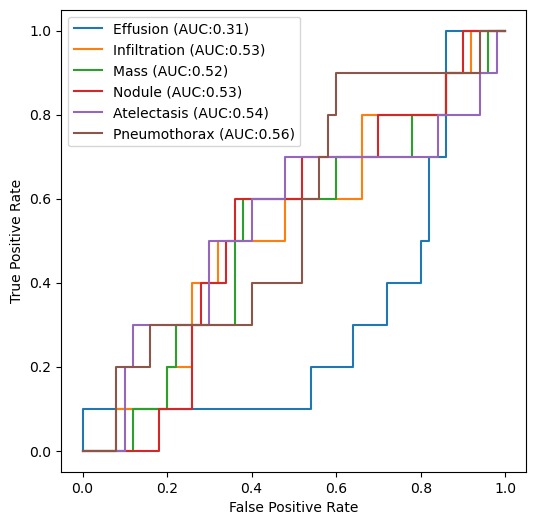

In [119]:
# Plotting ROC Curves
fig, c_ax = plt.subplots(1, 1, figsize=(6, 6))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), pred_Y[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
#fig.savefig('barely_trained_net.png')